# MODELO A - DATASET GRANDE - NO ILUMINACION

Declaramos las librerias a usar

We Declare the libraries to use 

In [1]:
import os
import zipfile
import tensorflow as tf
import keras
import gdown
import zipfile
import tensorflow as tf
import keras_preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from os.path import exists

Descargamos nuestro dataset de google drive a nuestra carpeta temporal:  "/tmp/vehdata"

Download our dataset from google drive and store it on our local machine on the address: "/tmp/vehdata"

In [2]:
#Checamos si existe un folder con nuestro conjunto de datos en nuestra carpeta temporal, si no entonces creamos uno 
#Check if the folder for our data set exist, if not we create the folder 
if not os.path.exists('/tmp/LD'):
    os.mkdir('/tmp/LD')

#Si ya descargamos el archivo .zip, no es necesario bajarlo de nuevo y omitimos este paso 
#if we already downloaded the zip file, this step will be omited 
if  exists('/tmp/LD/vehdata_full') == False : 

    #Descargamos nuestro dataset 
    #Download Dataset 
    url = 'https://drive.google.com/uc?id=1kQEtwys5dz5Sl11zUcy05bqJcBceTJyA'
    output = '/tmp/LD/vehdata.zip'
    gdown.download(url, output, quiet=False)

    #Descomprimiendo el archivo comprimido 
    #Unzipping the zip file 
    local_zip = '/tmp/LD/vehdata.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/tmp/LD')
    zip_ref.close()





Creamos los directorios de nuestro conjunto de datos 

Specify our training and validation folders 

In [3]:


base_dir = '/tmp/LD/vehdata_full'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio para las imagenes de entrenamiento SIN infantes
# Directory with our training pictures WITH NO infants 
train_empty_dir = os.path.join(train_dir, 'empty')

# Directorio para las imagenes de entrenamiento CON infantes
# Directory with our training WITH infants in the car
train_infant_dir = os.path.join(train_dir, 'infant')

# Directorio para las imagenes de validacion SIN infantes
# Directory with our validation WITH NO infants
validation_empty_dir = os.path.join(validation_dir, 'empty')

# Directorio para las imagenes de validacion CON infantes
# Directory with our validation WITH infants in the car
validation_infant_dir = os.path.join(validation_dir, 'infant')

Utilizamos tecnicas de aumento de datos, para crear mas imagenes de entrenamiento y mejorar nuestra red convolucional

We use data aumentation to increase the size of our training data set, which would improve our convolutional neural network

In [4]:



TRAINING_DIR = "/tmp/LD/vehdata_full/train/"
train_datagen = ImageDataGenerator(
      rescale = 1./255)
#	rotation_range=40,
#      width_shift_range=0.2,
#      height_shift_range=0.2,
#      shear_range=0.2,
#      zoom_range=0.2,
#      horizontal_flip=True,
#      fill_mode='nearest')

VALIDATION_DIR = "/tmp/LD/vehdata_full/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Imagenes de entrenamiento en grupos de 20 usando el generador train_datagen 
# Training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Imagenes de validacion en grupos de 20 usando el generador validation_datagen 
# Validation images in batches of 20 using validation_datagen generator
validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 6202 images belonging to 2 classes.
Found 798 images belonging to 2 classes.


Creamos el modelo de la red neuronal con 4 capaz convolucionales y una capa oculta.

Define a CNN model with 4 convolutional layers and 1 hiden layer. 

In [5]:
model = tf.keras.models.Sequential([
    # Primera convolucion
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolucion
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Tercera convolucion
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Cuarta convolucion
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # capa flatten 
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    #capa oculta con 512 neuronas
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')



])


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-27 19:51:37.153803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-27 19:51:37.154227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Creamos a "callback" para parar el entrenamiento de nuestra red neuronal cuando alcanzemos un determinado valor de precision. 

Declare a callback so we can stop training whenever we hit 95% of accuracy in our training data

In [6]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Seleccionamos la metrica que nos interesa, en este caso precision y 
    # establecemos el minimo acceptable que para este caso es 95%.
    # Select the metric we want to measure, on this escenario accuracy and 
    # indicate that we will be stoping training once we reach 95%.
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

Empezamos el entrenamiento de nuestra red neuronal 

Compile our CNN to start training 

In [7]:
# Seleccionamos funcion de perdida, ya que nuestro modelo es de 2 clases, 
# binary_crossentropy es usada para este typor de problemas.
# Segundo seleccionamos el optimizador que evaluara la prediccion y perdida 
# para asi optimizar nuestros pesos.
# We Select the loss function, since our problem have only 2 clases, we 
# select binary_crossentropy.
# secondly we will select an optimizer to better calculate the weights 
# in our CNN some examples are "Adam", "SGD", "RMSprop", etc. 

model.compile(loss = 'binary_crossentropy', optimizer="RMSprop", metrics=['accuracy'])


# Indicamos cuantos poasos por epoca asi como el numero de epocas, 
# finalmente declaramos nuestro callback que nos ayudara a deter el 
# entrenamiento cuando llegemos a 95% de precision. 
# We indicate steps per epoch and total epochs to run, notice we have 
# declared our callback to stop training once we hit 95% accuracy. 

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 100,
            validation_steps = 2,
            verbose = 2,
            callbacks=[callbacks])
model.save("Model_A.h5")

Epoch 1/100


2022-11-27 19:51:38.123691: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 19:51:38.496150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-27 19:52:09.112901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 - 33s - loss: 0.7227 - accuracy: 0.5470 - val_loss: 0.6397 - val_accuracy: 0.7000 - 33s/epoch - 663ms/step
Epoch 2/100
50/50 - 35s - loss: 0.6739 - accuracy: 0.6466 - val_loss: 0.5946 - val_accuracy: 0.8250 - 35s/epoch - 694ms/step
Epoch 3/100
50/50 - 36s - loss: 0.5617 - accuracy: 0.7240 - val_loss: 0.4076 - val_accuracy: 0.9000 - 36s/epoch - 716ms/step
Epoch 4/100
50/50 - 34s - loss: 0.4896 - accuracy: 0.7974 - val_loss: 0.4749 - val_accuracy: 0.7500 - 34s/epoch - 690ms/step
Epoch 5/100
50/50 - 34s - loss: 0.3687 - accuracy: 0.8422 - val_loss: 0.2199 - val_accuracy: 0.9750 - 34s/epoch - 688ms/step
Epoch 6/100
50/50 - 36s - loss: 0.2785 - accuracy: 0.8930 - val_loss: 0.4385 - val_accuracy: 0.8750 - 36s/epoch - 726ms/step
Epoch 7/100
50/50 - 35s - loss: 0.2354 - accuracy: 0.9100 - val_loss: 0.2123 - val_accuracy: 0.9250 - 35s/epoch - 696ms/step
Epoch 8/100
50/50 - 35s - loss: 0.2308 - accuracy: 0.9033 - val_loss: 0.2212 - val_accuracy: 0.9000 - 35s/epoch - 696ms/step
Epoch 9/100


Graficamos el entrenamiento de nuestra red neuronal, donde comparamos perdida, precision, perdida de entrenamiento y precision de entrenamiento durante las epocas que proceso. 

We plot the training process to have a visual comparison between loss, accuracy, val_loss & val_accuracy and their changes over the multiple epochs 

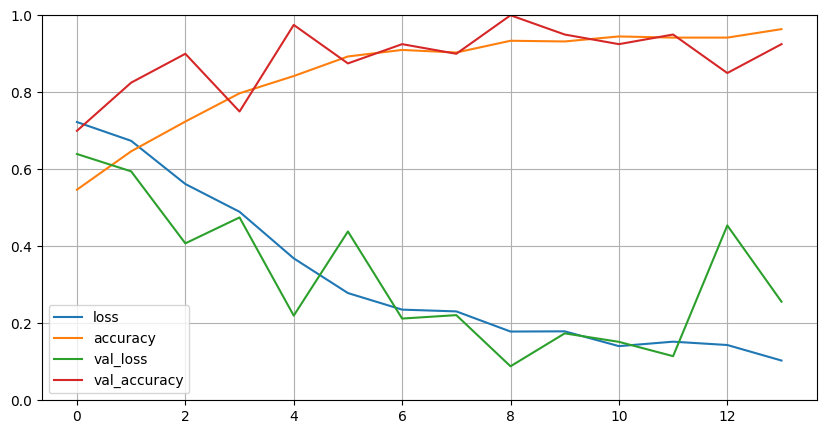

In [8]:

#Graficamos el entrenamiento de nuestro modelo desde la epoca 0 hasta la epoca donde se llego al 95% de precicion 
#Graph our model training history from the first epoch until we hit 95% accuracy 

pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Corremos preicciones con nuestro conjunto de validacion

Run predictions with our test set

In [9]:
#Definimos nuestro conjunto de validacion y empezamos a predecir las imagenes de validacion con nuestro modelo entrenado 
#Define validation set and predict our validation set classes using our model 
va_datagen = ImageDataGenerator(rescale = 1./255)
val = va_datagen.flow_from_directory( validation_dir,
                                                          batch_size=800,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))
Xtest, ytest = next(val)
predictions = model.predict(Xtest)

Found 798 images belonging to 2 classes.
 1/25 [>.............................] - ETA: 3s

2022-11-27 19:59:45.194629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 19ms/step


Creamos una matriz de confusion para visualizar el desempeño por clase.

Display a confusion matrix to visualize our 2 labels and their performance. 

Text(113.9222222222222, 0.5, 'Actual label')

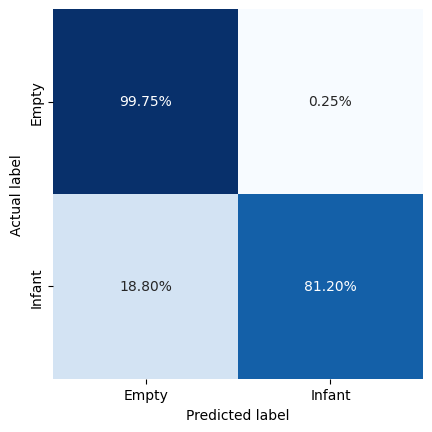

In [10]:
#Convertimos la probabilidad a clases, si es menor que 0.5 es clase 0, si es mayor a 0.5 es clase 1 
#convert to class 1 or 0 based on the probability obtained if more than 0.5 is 1, less than 0.5 is 0 
y_predicted = np.where(predictions > 0.5, 1, 0)
#creamos la matriz de confusion 
#built confusion matrix
cm = confusion_matrix(ytest, y_predicted)
#normalizamos la matrix para obtener porcentajes 
#normalize our confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#visualizamos al amtriz usando seaborn heatmap 
#plot the confusion matrix using seaborn 
labels = val.class_indices.keys()
sns.heatmap(cm, square=True, annot=True, fmt='.2%',  cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Mostramos precision recall y f1-score obtenido por nuestro modelo. 

Show key metrics of our model.

In [11]:
#obtenemos las metricas de nuestro modelo 
#print key metrics from our model 
print(classification_report(ytest, (y_predicted),target_names=val.class_indices.keys()))

              precision    recall  f1-score   support

       Empty       0.84      1.00      0.91       399
      Infant       1.00      0.81      0.90       399

    accuracy                           0.90       798
   macro avg       0.92      0.90      0.90       798
weighted avg       0.92      0.90      0.90       798

